In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [145]:
import datetime as dt
import time

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

##Connect variable creation
conn = engine.connect()

#dataframe creation using read_sql function from pandas; embedded date constraint to past year
prec_df = pd.read_sql("SELECT date,prcp FROM Measurement WHERE date>='2016-08-23'",conn)

#convert date to datetime type
prec_df['date'] = pd.to_datetime(prec_df['date'])

#set date column as index
prec_df = prec_df.set_index('date')

#sort by index (date)
prec_df.sort_index(ascending=False)

#drop NaNs
prec_df.dropna()


,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-17,0.13
2017-08-19,0.09
2017-08-21,0.56


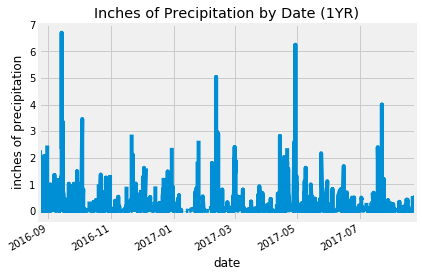

In [14]:
bar = prec_df['prcp'].plot()
plt.xlabel('date')
plt.ylabel('inches of precipitation')
plt.title('Inches of Precipitation by Date (1YR)')
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?

station_df = pd.read_sql("SELECT station,count(station) FROM Measurement GROUP BY station",conn)
station_df

,station,count(station)
0,USC00511918,1979
1,USC00513117,2709
2,USC00514830,2202
3,USC00516128,2612
4,USC00517948,1372
5,USC00518838,511
6,USC00519281,2772
7,USC00519397,2724
8,USC00519523,2669


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationlist = []
station_df.set_index('station')
station_df = station_df.sort_values(by='count(station)',ascending=False)
station_df

,station,count(station)
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_df = pd.read_sql("SELECT tobs FROM Measurement WHERE station='USC00519281'",conn)
low_temp = temp_df['tobs'].min()
high_temp = temp_df['tobs'].max()
avg_temp = temp_df['tobs'].mean()
print([(low_temp, high_temp, avg_temp)])

[(54.0, 85.0, 71.66378066378067)]


6    USC00519281
Name: station, dtype: object


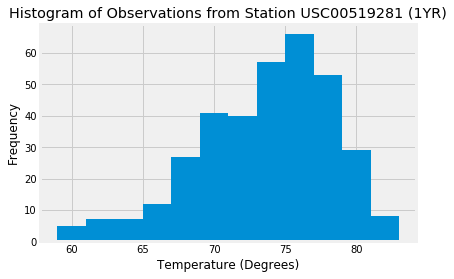

In [57]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_df_1yr_summary = pd.read_sql("SELECT station,count(tobs) FROM Measurement GROUP BY station",conn)

#dropna values from summary (as applicable)
temp_df_1yr_summary.dropna()

#identify highest # of observations using .max method
high_count = temp_df_1yr_summary['count(tobs)'].max()

#identify station with highest # of obs
high_station = temp_df_1yr_summary.loc[temp_df_1yr_summary['count(tobs)'] == high_count]
station = str(high_station['station'])
print(station)

#query last 12 months of temperature obs data for identified station and plot in a histogram (including titles and labels)
temp_df_1yr = pd.read_sql("SELECT tobs FROM Measurement WHERE date>='2016-08-23' AND station = 'USC00519281'",conn)
hist = temp_df_1yr['tobs'].plot.hist(bins=12)
plt.xlabel('Temperature (Degrees)')
plt.ylabel('Frequency')
plt.title('Histogram of Observations from Station USC00519281 (1YR)')
plt.show()


In [58]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [108]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prior_year_tempdata = calc_temps('2014-01-01', '2015-01-01')
print(prior_year_tempdata)

[(56.0, 73.2457757296467, 85.0)]


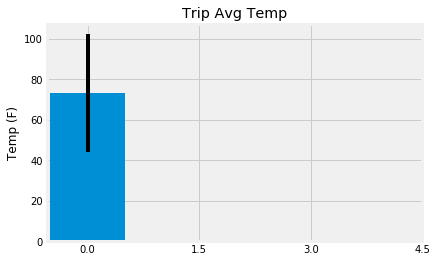

In [213]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmax = prior_year_tempdata[0][2]
tmin = prior_year_tempdata[0][0]
tave = prior_year_tempdata[0][1]
yerror = tmax-tmin
plt.bar(0,tave,yerr=yerror,width=1)
plt.xticks(np.arange(0,5, 1.5))
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.show()

In [131]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
data_all = pd.read_sql("SELECT Measurement.station, sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation FROM Measurement JOIN Station ON Measurement.station = Station.station WHERE date >='2014-01-01' and date <= '2015-01-01' GROUP BY Measurement.station",conn)
data_all = data_all.dropna()
data_all = data_all.sort_values('sum(Measurement.prcp)',ascending=False)
data_all = data_all.reset_index()
del data_all['index']
data_all

,station,sum(Measurement.prcp),name,latitude,longitude,elevation
0,USC00516128,144.55,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,89.85,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,58.42,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,45.93,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,39.31,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00511918,21.94,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
6,USC00519397,21.19,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
7,USC00517948,7.21,"PEARL CITY, HI US",21.39340,-157.97510,11.9
8,USC00518838,0.51,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6


## Optional Challenge Assignment

In [182]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [183]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
month_date = []

# Set the start and end date of the trip
startdate = '01-01-2014'
enddate = '01-01-2015'

# Use the start and end date to create a range of dates
numdays = 365
base = dt.datetime.strptime(enddate,'%m-%d-%Y')
date_list = [base - dt.timedelta(days=x) for x in range(numdays)]
date_list

# Stip off the year and save a list of %m-%d strings
for x in date_list:
    month_date.append(x.strftime('%m-%d'))

# Loop through the list of %m-%d strings and calculate the normals for each date
for combo in month_date:
    normals.append(daily_normals(combo))

print(normals)

[[(62.0, 69.15384615384616, 77.0)], [(56.0, 68.27906976744185, 77.0)], [(63.0, 69.86363636363636, 76.0)], [(57.0, 70.29166666666667, 78.0)], [(62.0, 70.52083333333333, 77.0)], [(62.0, 71.91666666666667, 79.0)], [(63.0, 71.44680851063829, 77.0)], [(60.0, 71.75, 79.0)], [(62.0, 70.0625, 78.0)], [(61.0, 70.34693877551021, 78.0)], [(67.0, 71.1304347826087, 77.0)], [(67.0, 72.13953488372093, 78.0)], [(65.0, 72.91304347826087, 81.0)], [(67.0, 72.0, 78.0)], [(63.0, 71.28, 77.0)], [(63.0, 70.64, 77.0)], [(60.0, 69.62264150943396, 82.0)], [(62.0, 71.34, 79.0)], [(65.0, 71.18, 78.0)], [(65.0, 70.9423076923077, 80.0)], [(64.0, 70.88235294117646, 79.0)], [(64.0, 72.38775510204081, 78.0)], [(61.0, 71.24528301886792, 78.0)], [(64.0, 71.90196078431373, 80.0)], [(60.0, 70.27450980392157, 83.0)], [(58.0, 69.2, 79.0)], [(61.0, 69.3921568627451, 78.0)], [(64.0, 70.92156862745098, 78.0)], [(66.0, 72.17647058823529, 81.0)], [(67.0, 72.88679245283019, 79.0)], [(62.0, 71.32692307692308, 77.0)], [(65.0, 71.91

In [197]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df1 = pd.DataFrame()
normals_df1['date'] = date_list
normals_df1['tmin'] = pd.DataFrame([[y[0] for y in x] for x in normals])
normals_df1['tavg'] = pd.DataFrame([[y[1] for y in x] for x in normals])
normals_df1['tmax'] = pd.DataFrame([[y[2] for y in x] for x in normals])
normals_df1 = normals_df1.set_index('date')
normals_df1

,tmin,tavg,tmax
date,,,
2015-01-01,62.0,69.153846,77.0
2014-12-31,56.0,68.279070,77.0
2014-12-30,63.0,69.863636,76.0
2014-12-29,57.0,70.291667,78.0
2014-12-28,62.0,70.520833,77.0
...,...,...,...
2014-01-06,61.0,68.964912,76.0
2014-01-05,56.0,67.964286,76.0
2014-01-04,58.0,70.000000,76.0


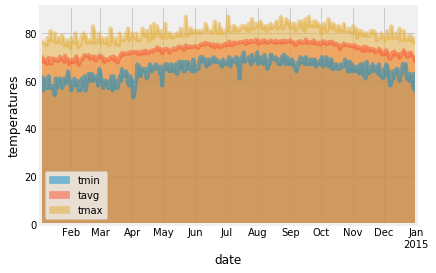

In [216]:
area = normals_df1.plot.area(stacked=False)
plt.xlabel('date')
plt.ylabel('temperatures')
plt.show()